## Import Packages

In [1]:
# torchsummary 可以讓模型視覺化，以及匯出模型每層的詳細數量和每層的比例。
!pip install torchsummary

In [2]:
import pydicom
import pandas as pd
import numpy as np
import os
import random

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, Subset, DataLoader
from torchvision.transforms import v2
import torchvision.models as models # VGG16, ResNet50
from torchsummary import summary # summary for models

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score


import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

## Configuration

In [41]:
class config:
    
    root = "/kaggle/input/dl-hw2"
    batch_size = 16
    lr = 1e-4
    epochs = 60
    weight_decay = 1e-3
    seed = 42
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_classes = 3
    
print('device:', config.device)

device: cuda


## Input Data

In [4]:
train_data = pd.read_csv(os.path.join(config.root, 'train.csv'))
test_data = pd.read_csv(os.path.join(config.root, 'test.csv'))

print(f'Number of training samples: {train_data.shape[0]}')
print(f'Number of testing samples: {test_data.shape[0]}')

Number of training samples: 161
Number of testing samples: 41


In [5]:
train_data['Stage'].value_counts().sort_index()

Stage
1    44
2    42
3    75
Name: count, dtype: int64

## Defined functions

In [6]:
def seed_everything(seed):
    # Set Python random seed
    random.seed(seed)
    
    # Set NumPy random seed
    np.random.seed(seed)
    
    # Set PyTorch random seed for CPU and GPU
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    # Set PyTorch deterministic operations for cudnn backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def evaluator(preds, gts):
    preds = preds.cpu().numpy() if isinstance(preds, torch.Tensor) else preds
    gts = gts.cpu().numpy() if isinstance(gts, torch.Tensor) else gts
    acc = accuracy_score(preds, gts)
    f1 = f1_score(preds, gts, average = "macro")
    misclassification_rate = 1 - acc
    
    return acc, f1, misclassification_rate

def train_one_epoch(model, train_loader, optimizer, scheduler, criterion, device):
    # 作用是啟用 batch normalization 和 dropout。
    # 保證 BN 層能夠用到每個 batch 資料的平均值和變異數。對於 Dropout 是隨機取一部分網路連線來訓練更新參數。
    model.train() 
    
    train_loss = .0
    predictions, ground_truths = [], []
    
    for images, ages, genders, labels in train_loader:
        images = images.to(device = device, dtype = torch.float)
        ages = ages.to(device = device, dtype = torch.float)
        genders = genders.to(device = device, dtype = torch.float)
        labels = labels.to(device = device, dtype = torch.long)

        optimizer.zero_grad()
        logits = model(images, ages, genders)
        
        # Pytorch 中的分類損失函數（如 CrossEntropyLoss）期望 label 為 0 開始的整數。
        labels = torch.sub(labels, 1) # labels 1, 2, 3 -> 0, 1, 2
        loss = criterion(logits, labels)
        loss.backward()

        optimizer.step()

        train_loss += loss.item()
        preds = torch.argmax(logits, dim = 1)

        predictions.append(preds)
        ground_truths.append(labels)
    
    scheduler.step()

    train_loss /= len(train_loader)

    predictions = torch.cat(predictions)
    ground_truths = torch.cat(ground_truths)
    train_acc, train_f1, train_misclass = evaluator(predictions, ground_truths)

    return train_loss, 100*train_acc, 100*train_f1, 100*train_misclass


def validation(model, valid_loader, criterion, device):
    # 確保 BN 層能夠用全部訓練資料的平均值和變異數，即驗證過程中要保證 BN 層的平均值和變異數不變。對於 Dropout 是利用了所有網路連接，即不進行隨機捨棄神經元。
    # pytorch 會自動把 BN 和 DropOut 固定住，不會取平均，而是用訓練好的數值。
    model.eval()
    valid_loss = .0
    predictions, ground_truths = [], []

    # 這邊禁用 PyTorch 梯度的自動計算，因為在 validation 階段我們不需要更新 model 的權重，因此不需要進行反向傳播(backpropagation)和梯度計算。
    with torch.no_grad():
        for images, ages, genders, labels in valid_loader:
            images = images.to(device=device, dtype=torch.float) 
            ages = ages.to(device=device, dtype=torch.float)
            genders = genders.to(device=device, dtype=torch.float)
            labels = labels.to(device=device, dtype=torch.long)

            logits = model(images, ages, genders)
            labels = torch.sub(labels, 1)
            loss = criterion(logits, labels)

            valid_loss += loss.item()
            preds = torch.argmax(logits, dim=1) 

            predictions.append(preds)
            ground_truths.append(labels)

        valid_loss /= len(valid_loader)

        predictions = torch.cat(predictions)
        ground_truths = torch.cat(ground_truths)
        
        valid_acc, valid_f1, valid_misclass = valid_acc, valid_f1, valid_misclass = evaluator(predictions, ground_truths)
        
    return valid_loss, 100*valid_acc, 100*valid_f1, 100*valid_misclass

## Transformation

In [7]:
class Normalization(object):
    
    def __call__(self, image): # 定義有image之後要進行的資料處理
        changed_image = (image - image.min())/(image.max() - image.min())
        return changed_image

def build_transform(is_train):
    """
    Create a data transformation pipeline for image preprocessing in deep learning tasks.
    """
    t = []
    if is_train:
        # 若是包含 Random 系列的圖像增強，則只能加在train裡面
        t.append(v2.CenterCrop(size = (50, 50)))
        t.append(Normalization())
        return v2.Compose(t)
    
    t.append(v2.CenterCrop(size = (50, 50)))
    t.append(Normalization())
    return v2.Compose(t)

## Defined Dataset

In [8]:
class ParkinsonsDataset(torch.utils.data.Dataset):

    def __init__(self, df, mode = None, transforms = None): # 將所有資料提出
        self.df = df
        self.mode = mode
        self.transforms = transforms
        
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, x): # 找出指定的資料
        
        age = torch.tensor(self.df.iloc[x, 1]) # 年齡
        gender = torch.tensor(self.df.iloc[x, 2]) # 性別
        index = torch.tensor(self.df.iloc[x, 4]) # 起始張數
        
        # 影像前處理
        image = pydicom.dcmread(config.root + self.df.iloc[x, 3]).pixel_array
        image = torch.tensor(image.astype(np.float32))
        image = image[index-1:index+2, :, :]
        
        if self.mode == "train":
            label = torch.tensor(self.df.iloc[x, 5]) # 標籤
            if self.transforms: image = self.transforms(image)

            return image, age, gender, label
        
        elif self.mode == "valid":
            label = torch.tensor(self.df.iloc[x, 5])
            return image, age, gender, label
    
        elif self.mode == "test":
            return image, age, gender

## Redefined VGG16

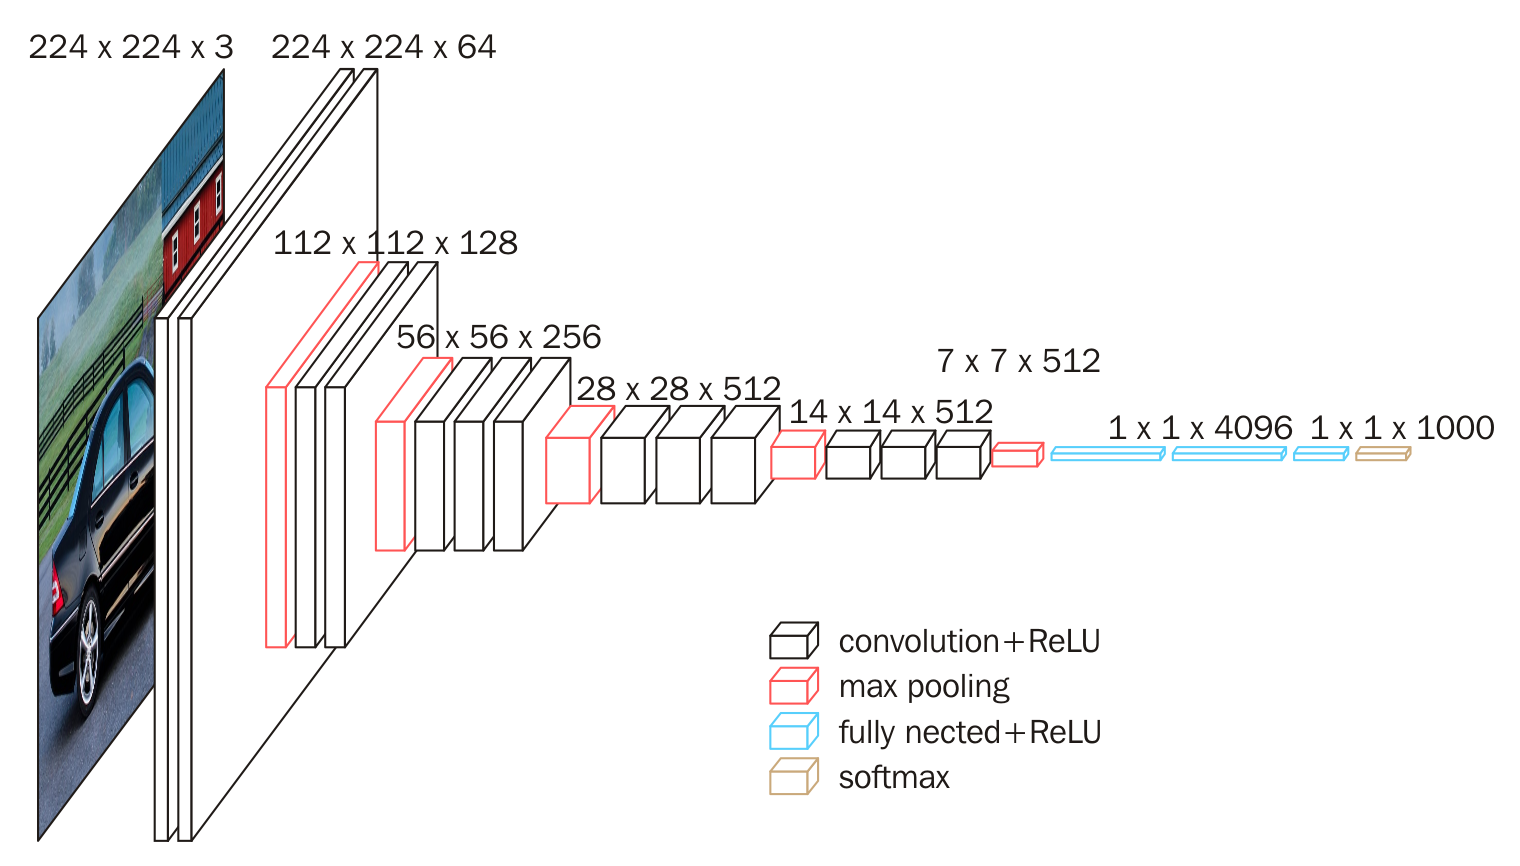

In [65]:
# VGG: Visual Geometry Group Network (視覺幾何群網絡)
# VGG16 的緣由: VGG 結構中有 13 個卷積層和 3 個全連接層

class VGGplus(nn.Module):
    def __init__(self, num_classes, input_size = (3, 50, 50), features_grad = False): # 默認輸出為分到每一類的機率
        super().__init__()
        
        # 取出 vgg16 中的特徵層
        vgg16 = models.vgg16(weights = 'IMAGENET1K_V1', progress = True) # progress = True：顯示下載進度條。
        
        # nn.Identity() 是 Pytorch 中的特殊層，不會改變輸入，只是作為佔位符。這樣你以方便修改模型結構而不會影響其整體的輸出 size
        vgg16.features[30] = nn.Identity()
        
        # 將 VGG16 的輸出特徵圖壓縮 1x1，可以得到一個 512 維的特徵向量，便於與後面的 Fully Connected Layer 結合並處理輸入的不同尺寸的圖像。
        vgg16.avgpool = nn.AdaptiveAvgPool2d(1)
        
        # 移除 VGG16 預設的分類器
        vgg16.classifier = nn.Identity()
        
        # 固定/不固定特徵層的參數值: False/True
        # features_grad: 控制是否對 VGG16 的特徵提取層進行微調(參與梯度計算)
        # 因為資料量不大，因此將 param.requires_grad 設為 False，只訓練新的分類層，減少訓練時間和 overfitting 風險。
        for param in vgg16.features.parameters():
            param.requires_grad = features_grad
        self.backend = vgg16
         
        # 增加分類層
        self.classifier = nn.Sequential(
            nn.Linear(514, num_classes)
        )

    def forward(self, x, age, gender):
        output = self.backend(x)
        outputs = torch.cat([output, age.view(-1, 1), gender.view(-1, 1)], dim = 1) # output size = (batch_size, 512), age size = (batch_size), age.view(-1, 1) size = (batch_size, 1), dim = 1; columns concat
        outputs = self.classifier(outputs) # outputs size = (batch_size, 3), 3: labels
        return outputs

In [10]:
model = VGGplus(num_classes = 3)
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 192MB/s] 


VGGplus(
  (backend): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16)

In [11]:
total_params = sum(p.numel() for p in model.parameters())
print("總參數量:", total_params)
del model

總參數量: 14716233


In [43]:
def main():
    seed_everything(config.seed)
    
    # train dataframe
    train_data = pd.read_csv(os.path.join(config.root, 'train.csv'))
    
    # split training & validation dataset 
    train_dataset, val_dataset = train_test_split(train_data, train_size = 0.8, test_size = 0.2, random_state = config.seed)

    train_dataset = ParkinsonsDataset(train_dataset, transforms = build_transform(True), mode = "train")
    val_dataset = ParkinsonsDataset(val_dataset, transforms = build_transform(False), mode = "valid")
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = config.batch_size, shuffle = True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = config.batch_size, shuffle = False)
    

    # settings
    print("Initializing model...")
    
    model = VGGplus(num_classes = config.num_classes, features_grad = True)
    
    model.to(config.device)
    
    criterion = nn.CrossEntropyLoss().to(config.device)
    
    parameters = [p for p in model.parameters() if p.requires_grad] 

    
    optimizer = torch.optim.Adam(parameters, lr = config.lr, weight_decay = config.weight_decay) 
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer = optimizer,
        epochs = config.epochs,
        steps_per_epoch = train_loader.__len__(),
        max_lr = config.lr,
        anneal_strategy = 'cos'
    )

    # recordings
    best_val_loss = float("inf")
    history = {
        "train": {
            "loss": [],
            "acc": [],
            "f1": [],
            "misclass": []
        },
        "valid": {
            "loss": [],
            "acc": [],
            "f1": [],
            "misclass": []
        },
    }
    for epoch in range(config.epochs):
        train_loss, train_acc, train_f1, train_misclass = train_one_epoch(model, train_loader, optimizer, scheduler, criterion, config.device)
        valid_loss, valid_acc, valid_f1, valid_misclass = validation(model, val_loader, criterion, config.device)
        
        # Log the loss and validation result
        history["train"]["loss"].append(train_loss)
        history["train"]["acc"].append(train_acc)
        history["train"]["f1"].append(train_f1)
        history["train"]["misclass"].append(train_misclass)
        history["valid"]["loss"].append(valid_loss)
        history["valid"]["acc"].append(valid_acc)
        history["valid"]["f1"].append(valid_f1)
        history["valid"]["misclass"].append(valid_misclass)

        print(f'Epoch[{epoch+1}/{config.epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Train F1: {train_f1:.2f}% | Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}%, Valid Misclass: {valid_misclass:.2f}% | LR: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')
        
        if valid_loss < best_val_loss:
            save_file = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "epoch": epoch,
                "args": config
            }
            best_val_loss = valid_loss
            torch.save(save_file, "checkpoint.pth")

        best_ckpt = torch.load("checkpoint.pth", map_location = config.device, weights_only = False)
        model.load_state_dict(best_ckpt["model"])

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["loss"], label='Training Loss')
    plt.plot(range(config.epochs), history["valid"]["loss"], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Curves')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["acc"], label='Training Acc')
    plt.plot(range(config.epochs), history["valid"]["acc"], label='Validation Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy Curves')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["f1"], label='Training F1')
    plt.plot(range(config.epochs), history["valid"]["f1"], label='Validation F1')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.title('Training and Validation F1 Score Curves')
    plt.show()
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["misclass"], label='Training misclassification')
    plt.plot(range(config.epochs), history["valid"]["misclass"], label='Validation misclassification')
    plt.xlabel('Epoch')
    plt.ylabel('misclassification')
    plt.legend()
    plt.title('Training and Validation misclassification Curves')
    plt.show()


Initializing model...
Epoch[1/60], Train Loss: 1.1368, Train Acc: 30.47%, Train F1: 23.35% | Valid Loss: 6.2722, Valid Acc: 45.45%, Valid F1: 20.83%, Valid Misclass: 54.55% | LR: 0.000004
Epoch[2/60], Train Loss: 1.0923, Train Acc: 50.78%, Train F1: 32.02% | Valid Loss: 5.9558, Valid Acc: 45.45%, Valid F1: 20.83%, Valid Misclass: 54.55% | LR: 0.000004
Epoch[3/60], Train Loss: 1.0674, Train Acc: 50.00%, Train F1: 28.76% | Valid Loss: 5.8136, Valid Acc: 45.45%, Valid F1: 20.83%, Valid Misclass: 54.55% | LR: 0.000004
Epoch[4/60], Train Loss: 1.0451, Train Acc: 47.66%, Train F1: 23.30% | Valid Loss: 5.8400, Valid Acc: 45.45%, Valid F1: 20.83%, Valid Misclass: 54.55% | LR: 0.000004
Epoch[5/60], Train Loss: 1.0429, Train Acc: 47.66%, Train F1: 23.30% | Valid Loss: 5.7728, Valid Acc: 45.45%, Valid F1: 20.83%, Valid Misclass: 54.55% | LR: 0.000004
Epoch[6/60], Train Loss: 1.0245, Train Acc: 47.66%, Train F1: 23.30% | Valid Loss: 5.8401, Valid Acc: 45.45%, Valid F1: 20.83%, Valid Misclass: 54.5

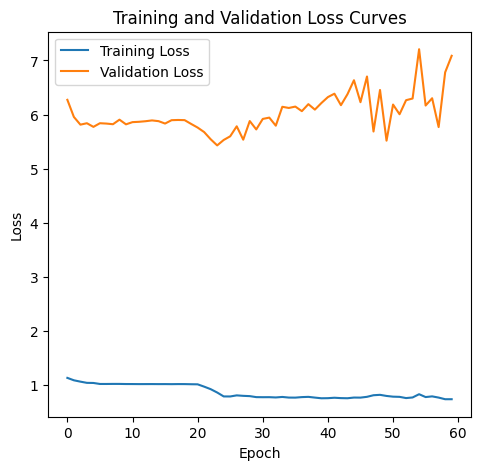

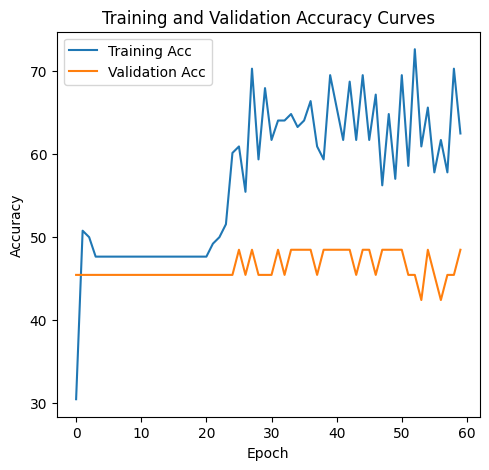

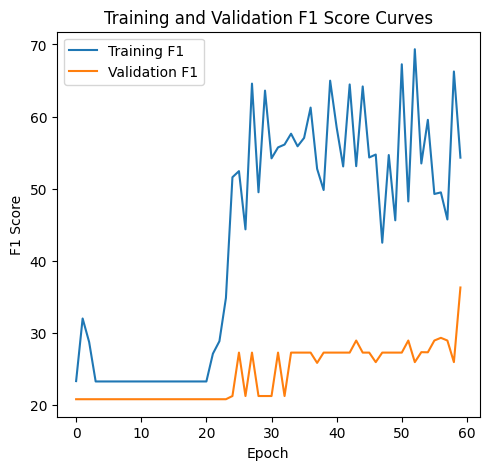

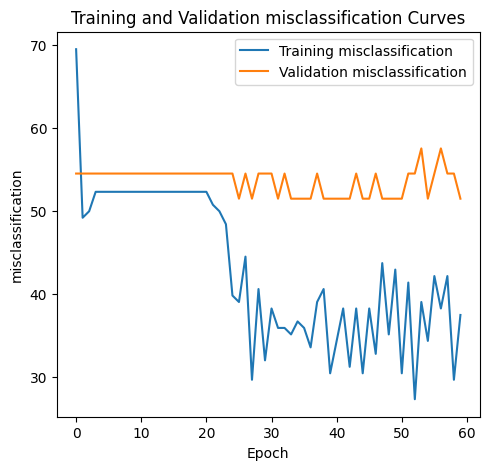

In [66]:
if __name__ == "__main__":
    main()

## testing

In [67]:
def testing(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad(): 
        for image, age, gender in test_loader:
            image = image.to(device = device, dtype = torch.float)
            age = age.to(device)
            gender = gender.to(device)
            logits = model(image, age, gender)
            pred = torch.argmax(logits, dim = 1)
            preds.append(pred)

    preds = torch.cat(preds)
    preds = torch.add(preds, 1)
    
    return preds

In [68]:
seed_everything(config.seed)
test_data = pd.read_csv(os.path.join(config.root, 'test.csv'))

test_dataset = ParkinsonsDataset(test_data, transforms = build_transform(False), mode="test")  # 使用 ParkinsonsDataset 創建測試數據集
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)  # 使用 DataLoader 創建數據加載器
model = VGGplus(num_classes = config.num_classes,features_grad = True)

model.to(config.device)

best_ckpt = torch.load(f"checkpoint.pth")
model.load_state_dict(best_ckpt["model"])

preds = testing(model, test_loader, config.device)

In [69]:
df = pd.read_csv(os.path.join(config.root, 'submission.csv'))
df = pd.DataFrame(df)
df['Stage'] = preds.cpu().numpy() # 將 preds 從 GPU 轉移到 CPU 並轉換為 NumPy 陣列
# df.to_csv('.csv',index = False, header = True)

In [70]:
answer_df = pd.read_csv('/kaggle/input/answer-csv/test_ans_hw2.csv')  # 檔名請根據實際更換
merged_df = pd.merge(df, answer_df, on='ID', suffixes=('_pred', '_true'))
correct = (merged_df['Stage_pred'] == merged_df['Stage_true']).sum()
total = len(merged_df)
accuracy = correct / total

print(f'準確率：{accuracy:.4f} ({correct}/{total})')

準確率：0.4634 (19/41)
